In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import anndata as ad
import numpy as np

import scanpy as sc
import ot
from sklearn.decomposition import PCA


from GraphST import GraphST 

In [26]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME']   = "/usr/local/lib/R"
os.environ['Renviron'] = "/usr/local/lib/R"

In [6]:
n_clusters = 7
dataset    = '151673'

In [17]:
def load_data():
    h5ad_file       = '1.DLPFC/151673/scRNA.h5ad'
    expression_file = '1.DLPFC/151673/filtered_feature_bc_matrix.h5'
    oprefix         = 'DLPFC-151673'
    
    adata_gene_expression = sc.read_visium('1.DLPFC/151673', count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata_gene_expression.var_names_make_unique()
    
    return adata_gene_expression

In [5]:
adata = load_data()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

adata.write_h5ad(filename="processed_adata")

Begin to train ST data...



00%|███████████████████████████████████████████████| 600/600 [12:37<00:00,  1.26s/it]

Optimization finished for ST data!


In [2]:
import numpy as np
import pandas as pd
from sklearn import metrics
import scanpy as sc
import ot
from sklearn.decomposition import PCA

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='emb_pca', random_seed=2020):
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']
    
    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def refine_label(adata, radius=50, key='label'):
    n_neigh = radius
    new_type = []
    old_type = adata.obs[key].values
    
    #calculate distance
    position = adata.obsm['spatial']
    distance = ot.dist(position, position, metric='euclidean')
           
    n_cell = distance.shape[0]
    
    for i in range(n_cell):
        vec  = distance[i, :]
        index = vec.argsort()
        neigh_type = []
        for j in range(1, n_neigh+1):
            neigh_type.append(old_type[index[j]])
        max_type = max(neigh_type, key=neigh_type.count)
        new_type.append(max_type)
        
    new_type = [str(i) for i in list(new_type)]    
    #adata.obs['label_refined'] = np.array(new_type)
    
    return new_type

def clustering(adata, n_clusters=7, radius=50, key='emb', method='mclust', start=0.1, end=3.0, increment=0.01, refinement=False):

    pca = PCA(n_components=20, random_state=42) 
    embedding = pca.fit_transform(adata.obsm['emb'].copy())
    adata.obsm['emb_pca'] = embedding
    
    if method == 'mclust':
       adata = mclust_R(adata, used_obsm='emb_pca', num_cluster=n_clusters)
       adata.obs['domain'] = adata.obs['mclust']

    if refinement:  
       new_type = refine_label(adata, radius, key='domain')
       adata.obs['domain'] = new_type 


In [37]:
adata = ad.read_h5ad("processed_adata")

In [38]:
os.environ['Renviron'] = "/usr/local/lib/R"
clustering(adata, n_clusters, refinement=True)

fitting ...

 |======================================================================| 100%

In [46]:
np.save("clustering_full", adata.obs["domain"].astype(int).to_numpy())

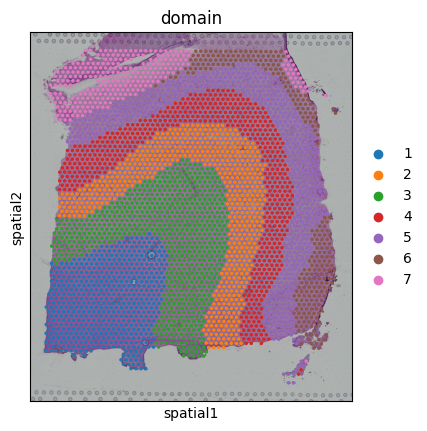

In [8]:
sc.pl.spatial(adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [21]:
discarded = np.load("discard.npy")
scdata    = load_data()

keep_ids   = np.setdiff1d(np.arange(scdata[:, :].shape[1]), discarded)
filt_adata = scdata[:, keep_ids].copy()

model      = GraphST.GraphST(filt_adata, device=device)
filt_adata = model.train()

filt_adata.write_h5ad(filename="filt_processed_adata")



/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [50]:
filt_adata = ad.read_h5ad("filt_processed_adata")
os.environ['Renviron'] = "/usr/local/lib/R"
clustering(filt_adata, n_clusters, refinement=True)

fitting ...

 |======================================================================| 100%

In [53]:
np.save("clustering_filt", filt_adata.obs["domain"].astype(int).to_numpy())

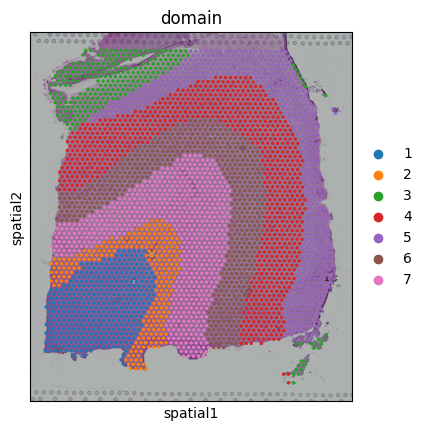

In [51]:
sc.pl.spatial(filt_adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [32]:
spat_var = np.load("spatially_variable_genes.npy")
scdata   = load_data()

filt_adata = scdata[:, spat_var].copy()

model      = GraphST.GraphST(filt_adata, device=device)
filt_adata = model.train()

filt_adata.write_h5ad(filename="spat_var_processed_adata")

filt_adata = ad.read_h5ad("spat_var_processed_adata")
os.environ['Renviron'] = "/usr/local/lib/R"
clustering(filt_adata, n_clusters, refinement=True)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Begin to train ST data...



00%|███████████████████████████████████████████████| 600/600 [12:22<00:00,  1.24s/it]

Optimization finished for ST data!
fitting ...

 |======================================================================| 100%

In [35]:
filt_adata = ad.read_h5ad("spat_var_processed_adata")
os.environ['Renviron'] = "/usr/local/lib/R"
clustering(filt_adata, n_clusters, refinement=True)

fitting ...

 |======================================================================| 100%

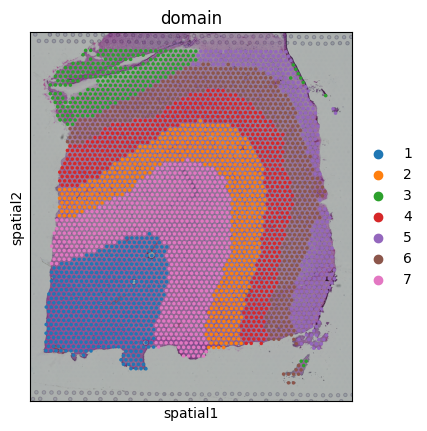

In [36]:
sc.pl.spatial(filt_adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [40]:
scdata = load_data()

min_gene_expression = 500
n_top               = 1000
sc.pp.normalize_total(scdata, target_sum=1e4)
sc.pp.log1p(scdata)
sc.pp.highly_variable_genes(scdata, flavor='seurat_v3', n_top_genes=30000)

var_rank = scdata.var["highly_variable_rank"].to_numpy()
var_rank = np.nan_to_num(var_rank, nan=np.nanmax(var_rank)+1)
max_rank = np.nanmax(var_rank)

tot_gene_expression    = scdata.X.toarray().sum(axis=0)
low_expression_indexes = np.where(tot_gene_expression < min_gene_expression)[0]
var_rank[low_expression_indexes] = max_rank

smallest = np.argsort(var_rank)[:n_top]
smallest = smallest[(var_rank[smallest] != max_rank)]

print(smallest.shape)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


(1000,)


In [41]:
filt_adata = scdata[:, smallest].copy()

In [42]:
model      = GraphST.GraphST(filt_adata, device=device)
filt_adata = model.train()

filt_adata.write_h5ad(filename="filt_processed_adata")

Begin to train ST data...



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [05:08<00:00,  1.94it/s]

Optimization finished for ST data!


In [43]:
filt_adata = ad.read_h5ad("filt_processed_adata")
clustering(filt_adata, n_clusters, refinement=True)

fitting ...

 |======================================================================| 100%

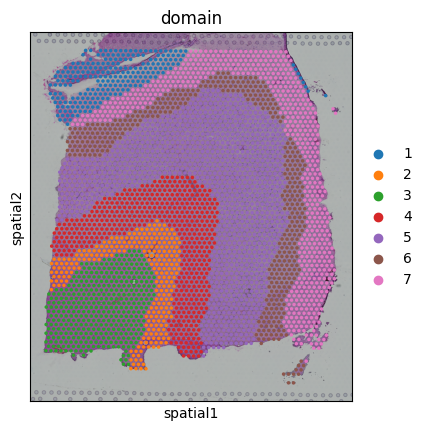

In [44]:
sc.pl.spatial(filt_adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [56]:
noise = np.load("noise.npy")

In [57]:
smallest_filt = np.setdiff1d(smallest, noise)

In [59]:
filt_denoised_adata = scdata[:, smallest_filt].copy()
model               = GraphST.GraphST(filt_denoised_adata, device=device)
filt_denoised_adata = model.train()

filt_denoised_adata.write_h5ad(filename="filt_denoised_processed_adata")

Begin to train ST data...



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [04:43<00:00,  2.12it/s]

Optimization finished for ST data!


In [63]:
filt_denoised_adata = ad.read_h5ad("filt_denoised_processed_adata")
clustering(filt_denoised_adata, n_clusters, refinement=True)

fitting ...

 |======================================================================| 100%

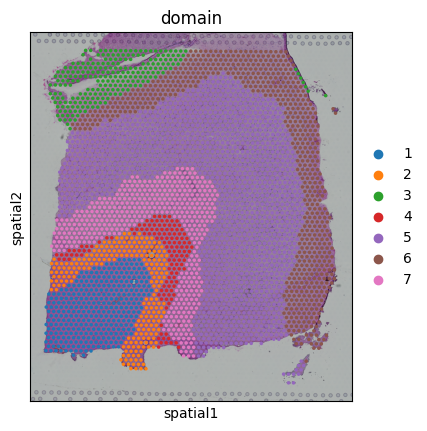

In [64]:
sc.pl.spatial(filt_denoised_adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [33]:
scdata = load_data()

min_gene_expression = 500
n_top               = 1000
sc.pp.normalize_total(scdata, target_sum=1e4)
sc.pp.log1p(scdata)
sc.pp.highly_variable_genes(scdata, flavor='seurat_v3', n_top_genes=30000)

var_rank = scdata.var["highly_variable_rank"].to_numpy()
var_rank = np.nan_to_num(var_rank, nan=np.nanmax(var_rank)+1)
max_rank = np.nanmax(var_rank)

tot_gene_expression    = scdata.X.toarray().sum(axis=0)
low_expression_indexes = np.where(tot_gene_expression < min_gene_expression)[0]
var_rank[low_expression_indexes] = max_rank

smallest = np.argsort(var_rank)[:n_top]
smallest = smallest[(var_rank[smallest] != max_rank)]

print(smallest.shape)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


(1000,)


In [39]:
noise_filt = np.load("noise_filt.npy")
idx_filt   = np.setdiff1d(smallest, noise_filt)
filt_denoised_adata = scdata[:, idx_filt].copy()
noise_filt.shape[0], filt_denoised_adata.shape[1]

(59, 951)

In [40]:
noise_filt

array([17855, 17153, 17854, 25081,  2003, 26017, 33360, 12632, 19604,
       13004,  2425,  5098, 11378, 20944,  2052, 11669, 26019, 21648,
       31843, 17059, 21000, 20872, 22013, 28822,  7609, 24150,  5727,
       26020, 26340, 20313, 10135,  6919, 15340, 30112, 16909, 17843,
        7206, 13837, 14651, 12644,  7789,  9566, 28336,  5053, 11471,
       11896, 21213, 23034, 23338,   876, 16907,  2578, 26425, 30763,
       30119,  8375, 18883,  2339,  1528])

In [36]:
model               = GraphST.GraphST(filt_denoised_adata, device=device)
filt_denoised_adata = model.train()
filt_denoised_adata.write_h5ad(filename="filt_denoised3_processed_adata")

Begin to train ST data...



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [05:06<00:00,  1.96it/s]

Optimization finished for ST data!


In [37]:
filt_denoised_adata = ad.read_h5ad("filt_denoised3_processed_adata")
clustering(filt_denoised_adata, n_clusters, refinement=True)

fitting ...

 |======================================================================| 100%

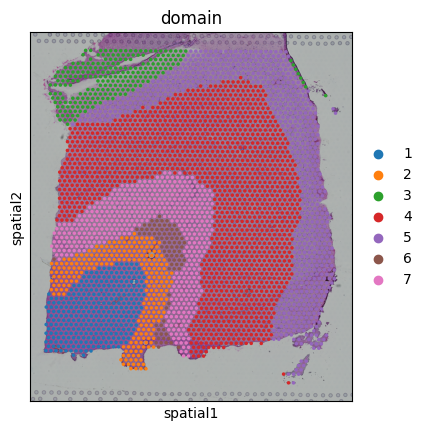

In [38]:
sc.pl.spatial(filt_denoised_adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [41]:
scdata = load_data()

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [42]:
model = GraphST.GraphST(adata, device=device)
adata = model.train()

Begin to train ST data...



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [14:13<00:00,  1.42s/it]

Optimization finished for ST data!


In [43]:
clustering(adata, n_clusters, refinement=True)

fitting ...

 |======================================================================| 100%

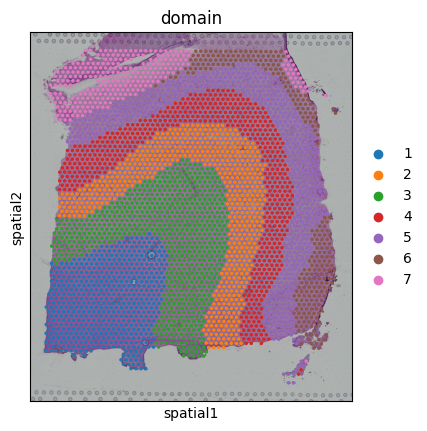

In [44]:
sc.pl.spatial(adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [45]:
scdata = load_data()
sc.pp.normalize_total(scdata, target_sum=1e4)
sc.pp.log1p(scdata)
sc.pp.highly_variable_genes(scdata, flavor='seurat_v3', n_top_genes=30000)

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [46]:
model = GraphST.GraphST(adata, device=device)
adata = model.train()
clustering(adata, n_clusters, refinement=True)

Begin to train ST data...



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [13:06<00:00,  1.31s/it]

Optimization finished for ST data!
fitting ...

 |======================================================================| 100%

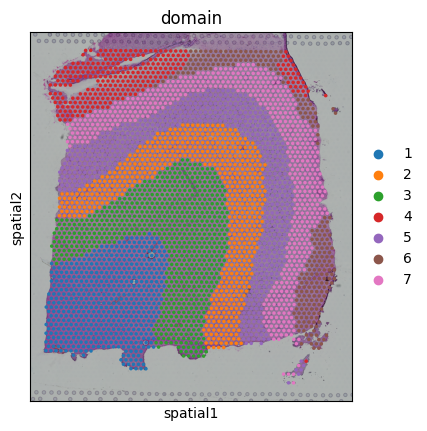

In [47]:
sc.pl.spatial(adata,
              img_key = "hires",
              color   = "domain",
              show=True)

In [55]:
scdata     = load_data()
noise_filt = np.load("noise_filt.npy")
idx_filt   = np.setdiff1d(np.arange(0, len(scdata.var.index)), noise_filt)
filt_denoised_adata = scdata[:, idx_filt].copy()
noise_filt.shape[0], filt_denoised_adata.shape[1]

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


(59, 33479)

In [56]:
model = GraphST.GraphST(filt_denoised_adata, device=device)
filt_denoised_adata = model.train()
clustering(filt_denoised_adata, n_clusters, refinement=True)

Begin to train ST data...



00%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [13:22<00:00,  1.34s/it]

Optimization finished for ST data!
fitting ...

 |======================================================================| 100%

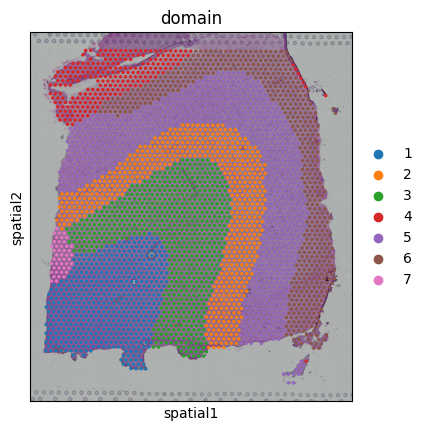

In [57]:
sc.pl.spatial(filt_denoised_adata,
              img_key = "hires",
              color   = "domain",
              show=True)